In [6]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50 # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # type: ignore
from tensorflow.keras.models import Model # type: ignore

import cv2
import matplotlib.pyplot as plt

In [2]:
# Load datasets from the specified directory
train_dataset = tf.data.Dataset.load('C:/Users/PC_I/OneDrive/Desktop/EDC/TF/train_dataset')
val_dataset = tf.data.Dataset.load('C:/Users/PC_I/OneDrive/Desktop/EDC/TF/val_dataset')
test_dataset = tf.data.Dataset.load('C:/Users/PC_I/OneDrive/Desktop/EDC/TF/test_dataset')

In [3]:
# Function to resize images to 224x224
def resize_image(image, label):
    image = tf.image.resize(image, [224, 224]) # default input size for ResNet50
    return image, label

# Apply the resizing to the train, validation, and test datasets
train_dataset = train_dataset.map(resize_image)
val_dataset = val_dataset.map(resize_image)
test_dataset = test_dataset.map(resize_image)

In [4]:
# Assuming you have a TensorFlow dataset

# For example: train_dataset, val_dataset, test_dataset
for image, label in train_dataset.take(1):
    print("Data type of images:", image.dtype)
    print("Data type of labels:", label.dtype)
    print("Image batch shape:", image.shape)
    print("Label batch shape:", label.shape)

Data type of images: <dtype: 'float32'>
Data type of labels: <dtype: 'int32'>
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


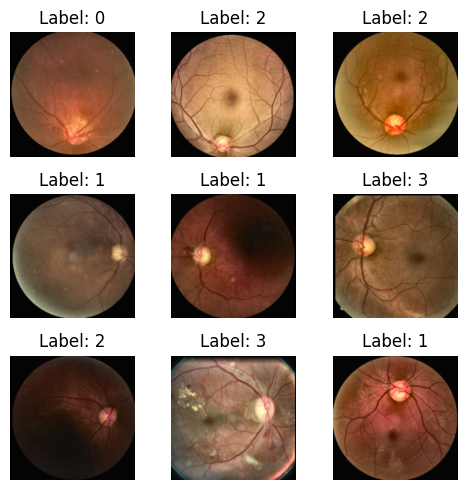

In [9]:
def display_sample_grid(dataset, num_samples=9, grid_size=(3, 3)):
    # Set up the grid
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(5, 5))
    
    # Flatten the axes for easy iteration
    axes = axes.flatten()
    
    # Take the specified number of samples from the dataset
    count = 0
    for batch_images, batch_labels in dataset:
        for image, label in zip(batch_images, batch_labels):
            if count >= num_samples:
                break
            
            # Convert image from tensor to numpy and from RGB to BGR (for OpenCV compatibility)
            image = image.numpy()  # Convert tensor to numpy
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
            
            # Plot each image in the corresponding grid cell
            axes[count].imshow(image)
            axes[count].set_title(f'Label: {label.numpy()}')
            axes[count].axis('off')  # Hide the axes for a cleaner look
            
            count += 1
        if count >= num_samples:
            break
    
    plt.tight_layout()  # Adjusts the spacing between subplots
    plt.show()

# Test with training dataset, displaying 9 images in a 3x3 grid
display_sample_grid(train_dataset, num_samples=9, grid_size=(3, 3))


In [10]:
# Load ResNet50 with pre-trained weights, exclude the top layers
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
# Freeze the base model to prevent retraining
base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 35s 0us/step


In [11]:
# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling
x = Dense(512, activation='relu')(x)  # Add a fully connected layer
x = Dropout(0.5)(x)  # Dropout with a rate of 50%
predictions = Dense(4, activation='softmax')(x)  # Output layer (for 4 classes)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


In [14]:
# Define the callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitoring validation accuracy
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='max',  # Stops training when the quantity monitored has stopped increasing
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity)
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='C:/Users/PC_I/OneDrive/Desktop/EDC/model_epoch_{epoch:02d}.weights.h5',  # Save file with epoch number
    monitor='val_accuracy',
    verbose=1,
    save_weights_only=True,
    save_best_only=False
)

# Add callbacks to the fit method
callbacks = [early_stopping, model_checkpoint]


In [15]:
# Assuming your datasets are already batched and preprocessed
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    epochs=15,
                    callbacks=callbacks) 


Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2648 - loss: 1.5797
Epoch 1: saving model to C:/Users/PC_I/OneDrive/Desktop/EDC/model_epoch_01.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 3s/step - accuracy: 0.2650 - loss: 1.5786 - val_accuracy: 0.3483 - val_loss: 1.3400
Epoch 2/15
48/80 ━━━━━━━━━━━━━━━━━━━━ 1:16 2s/step - accuracy: 0.3168 - loss: 1.3624

KeyboardInterrupt: 

In [17]:
# Print the number of parameters in your model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,741,134 (102.01 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2,102,282 (8.02 MB)